In [51]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))
from utils import save_data
SEED=1234
n_splits=10
import glob

In [60]:
train_dfs=sorted(glob.glob('./stacking/oof*.csv'))
test_dfs=sorted(glob.glob('./stacking/submit*.csv'))


In [61]:
# train=pd.read_csv('./input/prep_train1030.csv')

# def making_train_id_df(train,path='./submit/train_id.csv'):
#     '''使ったtrain_idを保持しておくDataFrameを作成する'''
#     train_id_df=pd.DataFrame()
#     train_id_df['id']=train['id'].values
#     train_id_df['traget']=train['賃料'].values
#     train_id_df.to_csv(path,header=None,index=None)

In [1]:
prep=lambda x:''.join(x.strip('.csv').split('_')[1:])
train_names=[prep(x) for x in train_dfs]
test_names=[prep(x) for x in test_dfs]

NameError: name 'train_dfs' is not defined

In [63]:
oof_df=pd.read_csv('./submit/train_id.csv',header=None).rename(columns={0:'id',1:'target'})
pred_df=pd.read_csv('./submit/sample_submit.csv',header=None).rename(columns={0:'id',1:'target'})



In [64]:
for name,path in zip(train_names,train_dfs):
    df=pd.read_csv(path,header=None).rename(columns={0:'id',1:'target'})
    oof_df=oof_df.merge(df,how='inner',on='id',suffixes=("",f'_{name}'))

for name,path in zip(test_names,test_dfs):
    df=pd.read_csv(path,header=None).rename(columns={0:'id',1:'target'})
    pred_df=pred_df.merge(df,how='inner',on='id',suffixes=("",f'_{name}'))

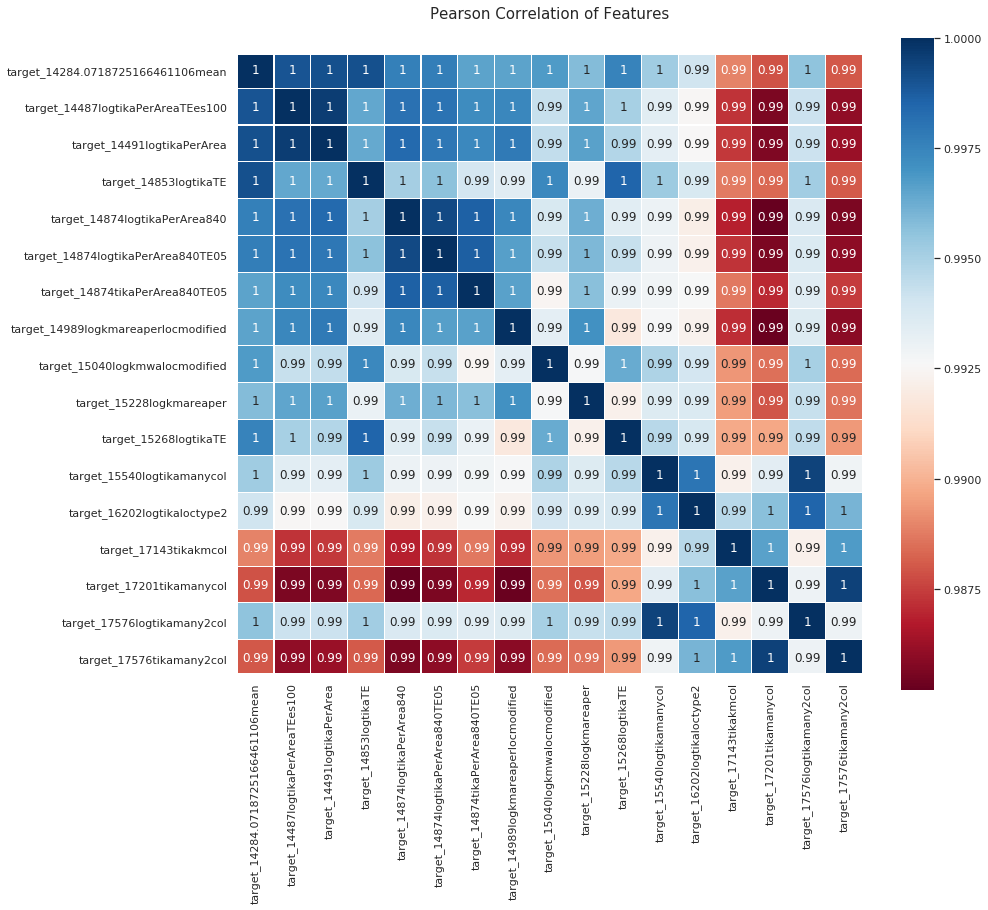

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(pred_df.drop(columns=['id','target']).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

plt.ylim([oof_df.drop(columns=['id','target']).shape[1]- 0.1, 0.1])
plt.show()

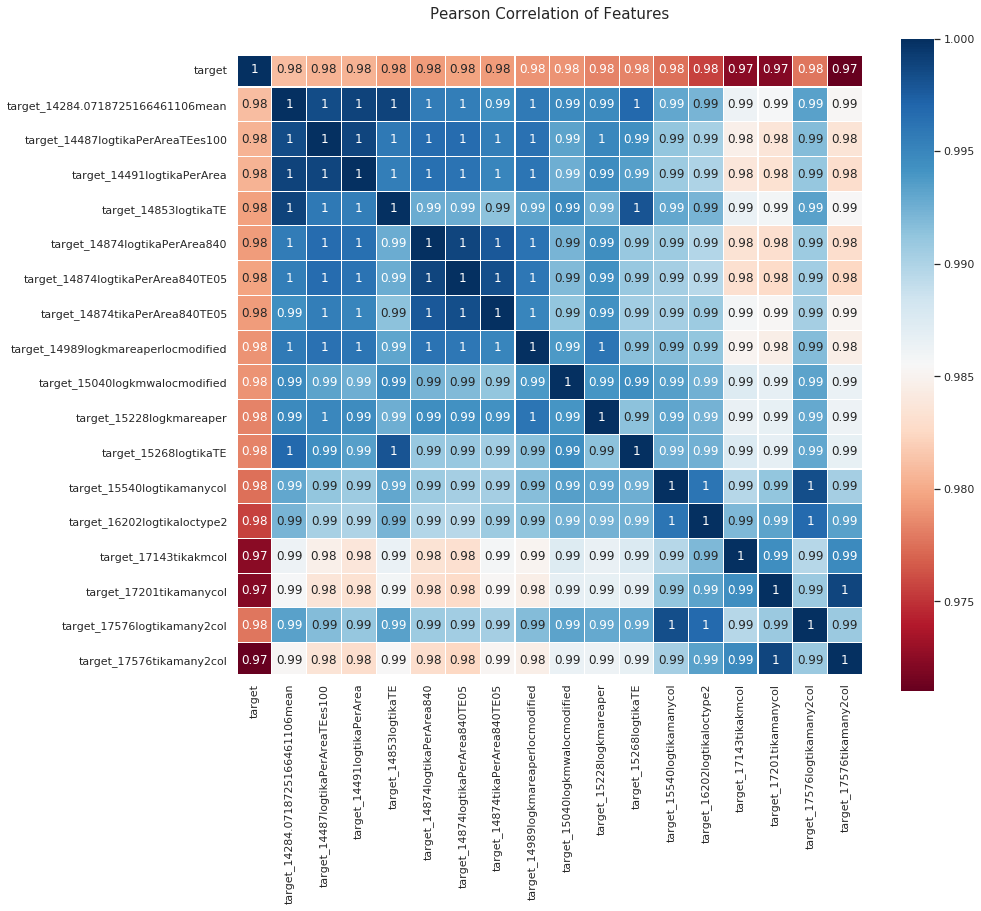

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(oof_df.drop(columns='id').astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

plt.ylim([oof_df.drop(columns='id').shape[1]- 0.1, 0.1])
plt.show()

In [16]:
pred_df.sort_values('mean',ascending=False).head(20)

KeyError: 'mean'

In [19]:
y_train=oof_df['target']
X_train=oof_df.drop(columns=['target','id'])
X_test=pred_df.drop(columns=['target','id'])

In [20]:
folder=KFold(n_splits=10, shuffle=True, random_state=42)

In [23]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }


# train

In [24]:
LGBM = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = LGBM.fit()

Training on fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[661]	training's l1: 0.0461754	valid_1's l1: 0.0466675
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[761]	training's l1: 0.0458841	valid_1's l1: 0.0484086
Training on fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[565]	training's l1: 0.046352	valid_1's l1: 0.0469822
Training on fold 4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[673]	training's l1: 0.0461787	valid_1's l1: 0.0454585
Training on fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[800]	training's l1: 0.0459355	valid_1's l1: 0.0465335
Training on fold 6
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[690]	training's l1: 0.0460704

### submit

In [77]:
pred_df['mean']=pred_df.drop(columns=['id','target']).mean(axis=1)

In [78]:
pred_df['pred']=lgbpreds

In [79]:
pred_df.loc[pred_df.query('50000<mean<500000').index,'mean']=pred_df.query('50000<mean<500000')['pred']

In [80]:
from pathlib import Path
save_path='./submit/1105_stacking3.csv'
if not Path(save_path).is_file():
    print('save')
    pred_df[['id','mean']].to_csv(save_path,header=None,index=None)

RMSE :  21076.454557037625
R^2 :  0.9058515207633709


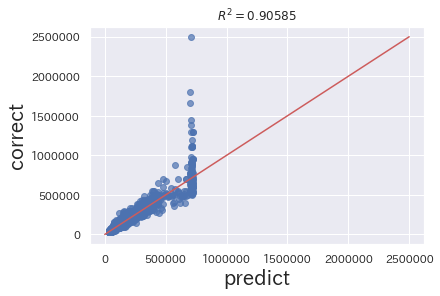

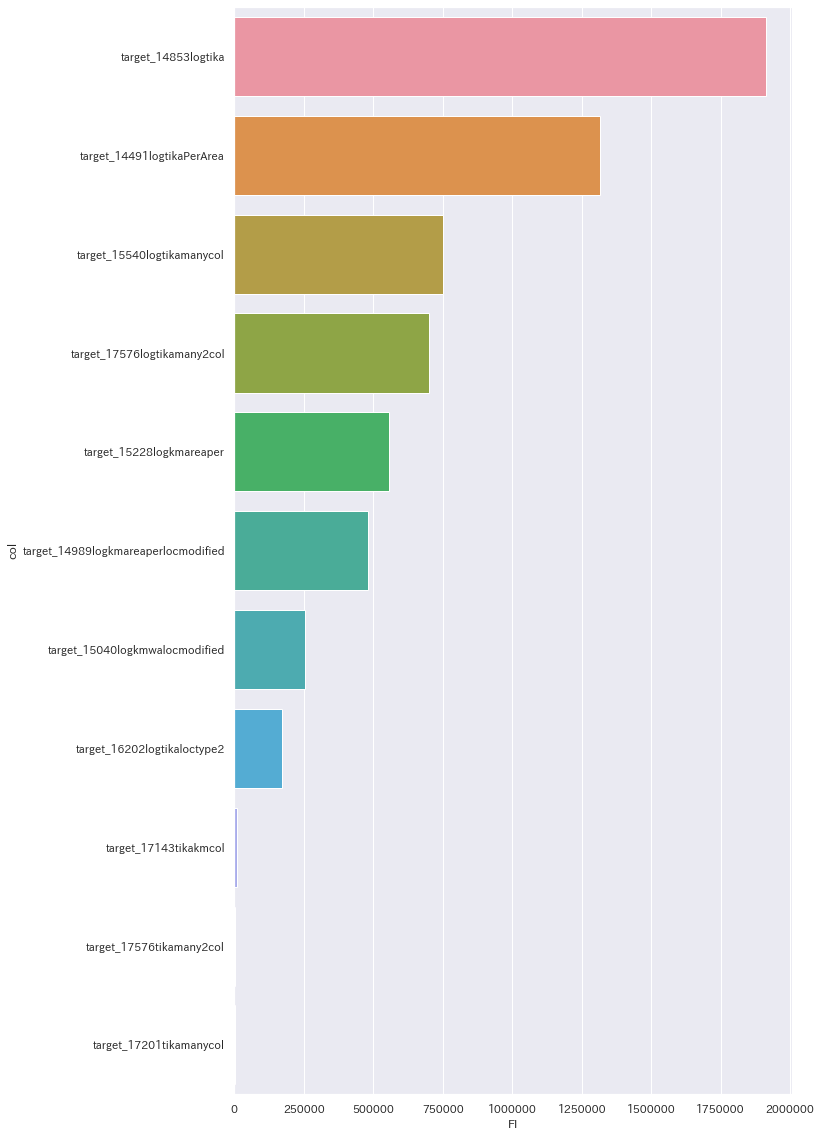

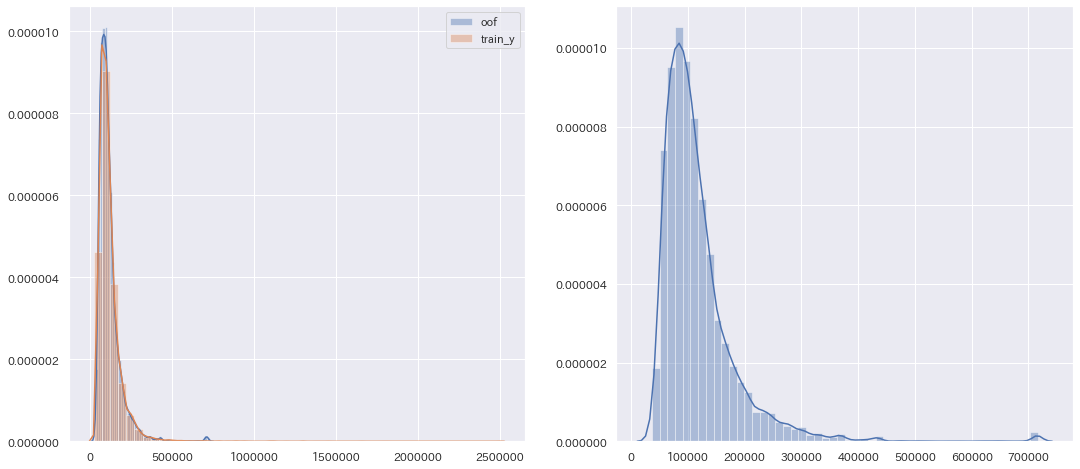

In [25]:
LGBM.plot_scatter_oofvspred()
LGBM.plot_FI(50)
LGBM.plot_pred_dist()

In [82]:
pred_df['mean'].sort_values()

15225    3.167102e+04
10165    3.176578e+04
7826     3.186427e+04
10473    3.251346e+04
11713    3.263577e+04
             ...     
30163    1.376068e+06
2184     1.497340e+06
559      1.512331e+06
2823     1.705543e+06
2032     1.959389e+06
Name: mean, Length: 31262, dtype: float64